In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

sns.set_theme()
sns.set(font_scale = 0.9)

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# Import Data

In [2]:
# 'Biological Data' sheet is where most info is
# 'Site Measurement Data' may also be useful

df_gns = pd.read_excel(r'.\raw_data\GNS Efish_2006-2020_For DM App.xlsx', sheet_name='Biological Data')
df_gns.columns = [x.strip().replace(' ', '_').upper() for x in df_gns.columns]

df_mar = pd.read_excel(r'.\raw_data\Margaree Efish_1957-2020_For DM App.xlsx', sheet_name='Biological Data')
df_mar.columns = [x.strip().replace(' ', '_').upper() for x in df_mar.columns]

# numeric columns with non numeric data

In [3]:
[x for x in df_gns['FORK_LENGTH'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan]

In [4]:
df_gns[df_gns['FORK_LENGTH'].isnull()].shape[0]

119

In [5]:
[x for x in df_gns['WEIGHT'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan, '4..14']

In [6]:
df_gns[df_gns['WEIGHT'].isnull()].shape[0], df_gns[df_gns['WEIGHT']=='4..14'].shape[0]

(245, 1)

In [7]:
[x for x in df_mar['FORK_LENGTH'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan,
 '21-25',
 '26-30',
 '31-35',
 '36-40',
 '41-45',
 '46-50',
 ' ',
 '76-80',
 '81-85',
 '86-90',
 '96-100']

In [8]:
(
    df_mar[df_mar.FORK_LENGTH.isnull()].shape[0],
    df_mar[df_mar.FORK_LENGTH.isin([x for x in df_mar['FORK_LENGTH'].dropna().unique() if not str(x).replace('.','',1).isnumeric()])].shape[0]
)
# null, other non-numeric

(9033, 40)

In [9]:
[x for x in df_mar['WEIGHT'].unique() if not str(x).replace('.','',1).isnumeric()]

[nan]

In [10]:
df_mar[df_mar['WEIGHT'].isnull()].shape[0]

19630

# convert numeric to numeric, coercing errors

In [11]:
# convert and coerce errors
df_gns['FORK_LENGTH'] = (pd.to_numeric(df_gns.FORK_LENGTH, errors='coerce') // 1).astype('Int64')
df_gns['WEIGHT'] = pd.to_numeric(df_gns.WEIGHT, errors='coerce')
df_mar['FORK_LENGTH'] = (pd.to_numeric(df_mar.FORK_LENGTH, errors='coerce') // 1).astype('Int64')
df_mar['WEIGHT'] = pd.to_numeric(df_mar.WEIGHT, errors='coerce')

# create weight bins for plotting

In [12]:
# one huge boi
df_mar[df_mar.WEIGHT>10000]

,ID,YEAR,SITE,CGNDB,SWEEP_NUMBER,SPECIES_ITIS_CODE,SPECIES,ORIGIN,FISH_STATUS,FORK_LENGTH,FORK_LENGTH_INTERVAL_WIDTH,TOTAL_LENGTH,WEIGHT,CATCH_FREQUENCY,FISH_SIZE,RIVER_AGE,AGE_TYPE,SEX,MATURITY,SCALE_ID_NUMBER,COMMENTS
12689,12690,1991,96,NaN,1,NaN,1781,W,RS,100,NaN,NaN,11600.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df_gns['WT_BIN'] = df_gns['WEIGHT'] // 1
df_gns.loc[df_gns.WT_BIN>100, 'WT_BIN'] = 100
df_mar['WT_BIN'] = df_mar['WEIGHT'] // 1
df_mar.loc[df_mar.WT_BIN>100, 'WT_BIN'] = 100

# describe the data

In [14]:
df_gns.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,12895.000,NaN,NaN,NaN,6448.000,3722.610,1.000,3224.500,6448.000,9671.500,12895.000
YEAR,12859.000,NaN,NaN,NaN,2013.612,4.303,2006.000,2010.000,2014.000,2017.000,2020.000
SITE,12859.000,32.000,4.000,2420.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RIVER_NAME,12859,16,River Philip,4114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWEEP_NUMBER,12859.000,NaN,NaN,NaN,0.500,0.000,0.500,0.500,0.500,0.500,0.500
SPECIES,12855.000,20.000,1731.000,10597.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,9964,2,W,9962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_STATUS,12859,6,RS,12616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH,12776.000,NaN,NaN,NaN,66.187,21.398,13.000,53.000,59.000,75.000,552.000
TOTAL_LENGTH,5.000,NaN,NaN,NaN,333.200,183.261,44.000,325.000,325.000,442.000,530.000


In [15]:
df_mar.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,44472.000,NaN,NaN,NaN,22236.500,12838.105,1.000,11118.750,22236.500,33354.250,44472.000
YEAR,44472.000,NaN,NaN,NaN,1994.686,16.001,1957.000,1986.000,1999.000,2005.000,2020.000
SITE,44472.000,115.000,51.000,5404.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CGNDB,7941,10,Margaree,2727,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SWEEP_NUMBER,41612.000,11.000,0.500,16974.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPECIES_ITIS_CODE,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SPECIES,44472.000,23.000,1731.000,36774.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORIGIN,44472,3,W,43370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FISH_STATUS,41124,7,RS,36910,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH,35399.000,NaN,NaN,NaN,74.678,24.468,11.000,55.000,75.000,91.000,700.000


# What are the differences between the two files?

### missing from gns

In [16]:
[x for x in df_mar.columns if x not in df_gns.columns]

['CGNDB', 'SPECIES_ITIS_CODE', 'FORK_LENGTH_INTERVAL_WIDTH']

In [17]:
df_mar.CGNDB.value_counts(dropna=False)

NaN         36531
Margaree     2727
CAMNO        1011
CBBWL         874
CATHP         668
CAWKZ         498
CBJVR         470
CACZB         443
CANHO         428
CARKU         427
CBPVG         395
Name: CGNDB, dtype: int64

In [18]:
# this is not a useful column
df_mar.SPECIES_ITIS_CODE.value_counts(dropna=False)

NaN    44472
Name: SPECIES_ITIS_CODE, dtype: int64

In [19]:
# this incomplete and redundant
df_mar.FORK_LENGTH_INTERVAL_WIDTH.value_counts(dropna=False).head(10)

NaN        40835
1           3521
81-85         11
96-100        10
86-90          9
71-75          8
91-95          8
76-80          8
101-105        8
106-110        7
Name: FORK_LENGTH_INTERVAL_WIDTH, dtype: int64

Null Data: 9073
Non-Null Data: 35399


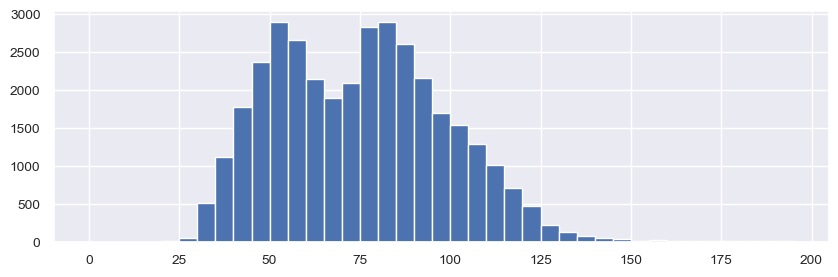

In [20]:
# way more information in fork_length
print('Null Data:', df_mar.FORK_LENGTH.isnull().sum())
print('Non-Null Data:', df_mar.FORK_LENGTH.notnull().sum())
df_mar.FORK_LENGTH.hist(bins=[x*5 for x in range(40)], figsize=(10,3));

### missing from mar

In [21]:
[x for x in df_gns.columns if x not in df_mar.columns]

['RIVER_NAME']

In [22]:
df_gns.RIVER_NAME.value_counts(dropna=False)

River Philip              4114
West River Antigonish     3515
East River Pictou         2872
West River Pictou          562
Mabou                      462
Wallace                    201
Barney River               169
Wallace River              158
River John                 157
Wallace River              154
Barneys River              126
Barneys                    125
Barney's River             113
Mabou River                 83
NaN                         36
North East Mabou            33
River John East Branch      15
Name: RIVER_NAME, dtype: int64

# Descriptive statistics

### NULL

In [23]:
(df_mar.isnull().sum() / df_mar.shape[0]).sort_values(ascending=False)

SPECIES_ITIS_CODE            1.000
MATURITY                     0.999
SCALE_ID_NUMBER              0.981
COMMENTS                     0.976
SEX                          0.931
FORK_LENGTH_INTERVAL_WIDTH   0.918
TOTAL_LENGTH                 0.869
CGNDB                        0.821
AGE_TYPE                     0.740
WEIGHT                       0.441
WT_BIN                       0.441
FORK_LENGTH                  0.204
RIVER_AGE                    0.195
FISH_SIZE                    0.174
FISH_STATUS                  0.075
SWEEP_NUMBER                 0.064
CATCH_FREQUENCY              0.000
YEAR                         0.000
ORIGIN                       0.000
SPECIES                      0.000
SITE                         0.000
ID                           0.000
dtype: float64

In [24]:
(df_gns.isnull().sum() / df_gns.shape[0]).sort_values(ascending=False)

TOTAL_LENGTH      1.000
MATURITY          0.998
SCALE_ID_NUMBER   0.961
COMMENTS          0.960
AGE_TYPE          0.929
SEX               0.854
RIVER_AGE         0.460
ORIGIN            0.227
FISH_SIZE         0.176
WEIGHT            0.019
WT_BIN            0.019
FORK_LENGTH       0.009
SPECIES           0.003
YEAR              0.003
FISH_STATUS       0.003
SWEEP_NUMBER      0.003
RIVER_NAME        0.003
SITE              0.003
CATCH_FREQUENCY   0.000
ID                0.000
dtype: float64

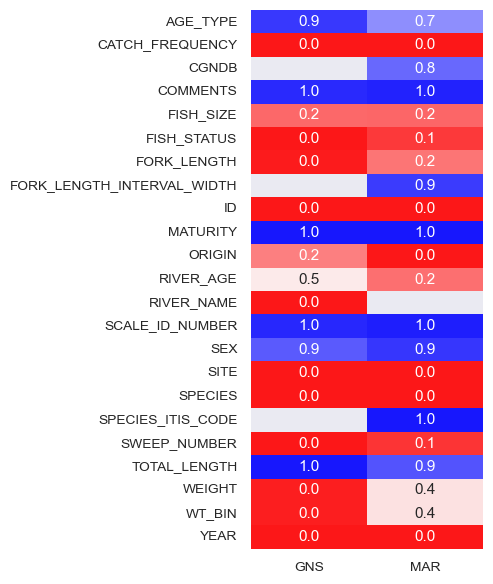

In [25]:
plt.figure(figsize=(3,7))
sns.heatmap(
    pd.concat([
        pd.DataFrame((df_gns.isnull().sum() / df_gns.shape[0]).sort_values(ascending=False), columns=['GNS']),
        pd.DataFrame((df_mar.isnull().sum() / df_mar.shape[0]).sort_values(ascending=False), columns=['MAR'])
    ], axis=1).sort_index(),
    cmap='bwr_r', annot=True, fmt='.1f', annot_kws={"fontsize":11}, cbar=False, alpha=0.9
)
plt.show()

### Data types

In [26]:
pd.concat([
    pd.DataFrame(df_gns.dtypes, columns=['gns_dtypes']),
    pd.DataFrame(df_gns.nunique(), columns=['gns_unique']),
    pd.DataFrame(df_mar.dtypes, columns=['mar_dtypes']),
    pd.DataFrame(df_mar.nunique(), columns=['mar_unique'])
], axis=1).sort_index()

,gns_dtypes,gns_unique,mar_dtypes,mar_unique
AGE_TYPE,object,2.000,object,3.000
CATCH_FREQUENCY,int64,43.000,float64,180.000
CGNDB,NaN,NaN,object,10.000
COMMENTS,object,48.000,object,72.000
FISH_SIZE,object,4.000,object,6.000
FISH_STATUS,object,6.000,object,7.000
FORK_LENGTH,Int64,170.000,Int64,194.000
FORK_LENGTH_INTERVAL_WIDTH,NaN,NaN,object,27.000
ID,int64,12895.000,int64,44472.000
MATURITY,object,1.000,object,1.000


In [27]:
def print_unique(dataframe):
    for col in dataframe.columns:
        print()
        print(col)
        if dataframe[col].nunique() > 100:
            print('number of unique values:', dataframe[col].nunique())
        else:
            print(dataframe[col].unique())


In [28]:
print_unique(df_gns)


ID
number of unique values: 12895

YEAR
[2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016.   nan
 2017. 2019. 2020. 2018.]

SITE
[996 'B' 998 2 3 'A' 1 8 4 997 'SP1' 999 98 99 5 10 'EF BRI' 6 7 '.'
 'SP 1' '1A' '8B' '8A' 9 '4B' 'P4' '7B' '8b' '7b' nan '9A' '6B']

RIVER_NAME
['Mabou' 'River Philip' 'Wallace' 'West River Antigonish'
 'West River Pictou' 'Barneys' 'East River Pictou' 'Wallace River '
 'Barneys River' 'Mabou River' 'North East Mabou' 'Barney River'
 'Wallace River' 'River John' 'River John East Branch' "Barney's River"
 nan]

SWEEP_NUMBER
[0.5 nan]

SPECIES
[1781 2630 1741 1731 140 2650 4220 2680 'Unkn' 4260 2610 2641 'frog' 2621
 3410 2640 nan 'DACE' 2651 4280 4110]

ORIGIN
[nan 'W' 'H']

FISH_STATUS
['RS' 'MS' 'R' 'MZ' 'L' 'M' nan]

FORK_LENGTH
number of unique values: 170

TOTAL_LENGTH
[ nan 325. 442. 530.  44.]

WEIGHT
number of unique values: 1748

CATCH_FREQUENCY
[  1   3  41  32 163  22  54  12 121   4  15  18  17  44 114   6  52  10
  11  59  67 11

In [29]:
print_unique(df_mar)


ID
number of unique values: 44472

YEAR
[1957 1986 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969
 1975 1976 1977 1978 1979 1987 1988 1991 1992 1993 1994 1995 1996 1997
 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011
 2012 2013 2014 2015 2016 2017 2018 2019 2020]

SITE
number of unique values: 115

CGNDB
[nan 'CBBWL' 'CBJVR' 'CATHP' 'CARKU' 'CAMNO' 'CAWKZ' 'CBPVG' 'CACZB'
 'CANHO' 'Margaree']

SWEEP_NUMBER
[1 2 3 4 6 5 nan 7 0 0.5 '1A' '1B']

SPECIES_ITIS_CODE
[nan]

SPECIES
[1731 1781 3410 2660 2680 4220 1751 4110 9999 2610 1519 4260 1741 4250 422
 140 1510 412 'worm' 'tadpole' 151 2600 1760]

ORIGIN
['W' 'H' 'NC']

FISH_STATUS
['R' 'RS' nan 'M' 'MS' 'RL' 'R ' 'M ']

FORK_LENGTH
number of unique values: 194

FORK_LENGTH_INTERVAL_WIDTH
[nan '41-45' '46-50' '51-55' '56-60' '61-65' '26-30' '31-35' '36-40'
 '101-105' '106-110' '121-125' '126-130' '131-135' '136-140' '146-150'
 '116-120' '111-115' '1221-125' '151-155' 1 '76-80' '81-85' '86-90'
 '91-95' 

In [30]:
def types_of_data(series):
    numbers, strings, blanks, n_null = 0, 0, 0, 0
    for item in series:
        if pd.isnull(item):
            n_null += 1
        else:
            try:
                float(item)
                numbers += 1
            except (ValueError):
                strings += 1
                if str(item) == ' ' or str(item) == '':
                    blanks += 1           
    # note: blanks are strings
    return numbers, strings, blanks, n_null


def print_data_info(dataframe, column):
    print('\n--------------------------------------------------\nData Info:', column.upper(), '\n')  
    numbers, strings, blanks, n_null = types_of_data(dataframe[column])  
    print('UNIQUE numbers, strings, blanks, null =', types_of_data(dataframe[column].unique()))
    print('number of numeric =', numbers)
    print('number of strings =', strings)
    print('number of blanks =', blanks)
    print('number of null = ', n_null)

    
def print_hist(dataframe, column, max_bins=100, colours=(0,2)):  
    print('\n--------------------------------------------------\nHistogram:', column.upper())   
    plt.figure(figsize=(10, 3))    
    n_unique = dataframe[column].nunique()
    
    if n_unique <= max_bins:
        bins = n_unique
    else:
        bins = max_bins  
    
    # if there are too many bins, rotate the text to make it readable
    if bins > 20:
        xrot = 90
    else:
        xrot = 0
        
    is_categorical = dataframe[column].dtype == 'object'
    if is_categorical:
        plot = dataframe[column].astype(str).sort_values().hist(
            bins=bins, xrot=90, color=sns.color_palette()[colours[1]]
        )
    else:
        plot = dataframe[column].hist(
            bins=bins, xrot=0, color=sns.color_palette()[colours[0]]
        )
    
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    plt.show()
    
    
def print_timeseries(dataframe, column, time_column, colours=(1,3)):
    print('\n------------------------------------------------\nTime Series:', column.upper(), sep='')
    plt.figure(figsize=(10, 3))
    
    # could make the categorical check an input variable, but this just works (albiet super clean)
    try:
        plot = sns.lineplot(
            x = dataframe[time_column], 
            y = dataframe[column].astype(float),  # cast int to float or get ValueErrors with IQR (pi 50)
            errorbar = ('pi', 50),  # IQR
            color = sns.color_palette()[colours[0]]
        )
        print('NUMERICAL')  # NOTE: some are actually categorical but stored as an int(eg, site), those averages don't have meaning
    except (ValueError, TypeError):  # categorical variables, can't cast to float
        plot = sns.lineplot(
            x = dataframe[time_column], 
            y = dataframe[column].astype(str).sort_values(),
            errorbar = ('pi', 50), 
            color = sns.color_palette()[colours[1]]
        )
        print('CATEGORICAL')  # NOTE: categorical variables treated as ordinal to make plotting possible, averages don't have meaning
        
    # show entire dataset time period for all plots
#     plot.set_xlim(1957, 2022)
    plot.yaxis.tick_right()  # so all of the graphs align with eachother, regarless of text length
    plt.show()
    
    
def do_EDA_stuff(dataframe, column, date_column='YEAR'):
    print_data_info(dataframe, column)
    print_hist(dataframe, column)
    print_timeseries(dataframe, column, date_column)

In [31]:
df_mar.YEAR.min(), df_gns.YEAR.min()

(1957, 2006.0)


--------------------------------------------------
Data Info: ID 

UNIQUE numbers, strings, blanks, null = (12895, 0, 0, 0)
number of numeric = 12895
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Data Info: YEAR 

UNIQUE numbers, strings, blanks, null = (15, 0, 0, 1)
number of numeric = 12859
number of strings = 0
number of blanks = 0
number of null =  36

--------------------------------------------------
Data Info: WEIGHT 

UNIQUE numbers, strings, blanks, null = (1748, 0, 0, 1)
number of numeric = 12649
number of strings = 0
number of blanks = 0
number of null =  246

--------------------------------------------------
Data Info: SCALE_ID_NUMBER 

UNIQUE numbers, strings, blanks, null = (0, 369, 0, 1)
number of numeric = 0
number of strings = 502
number of blanks = 0
number of null =  12393

--------------------------------------------------
Data Info: COMMENTS 

UNIQUE numbers, strings, blanks, null = (0, 48, 0, 1

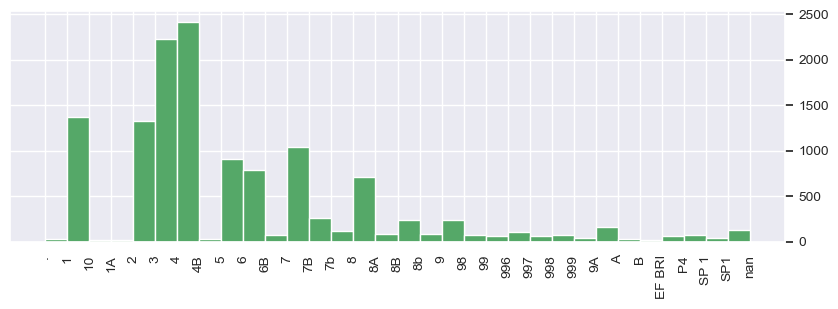


------------------------------------------------
Time Series:SITE
CATEGORICAL


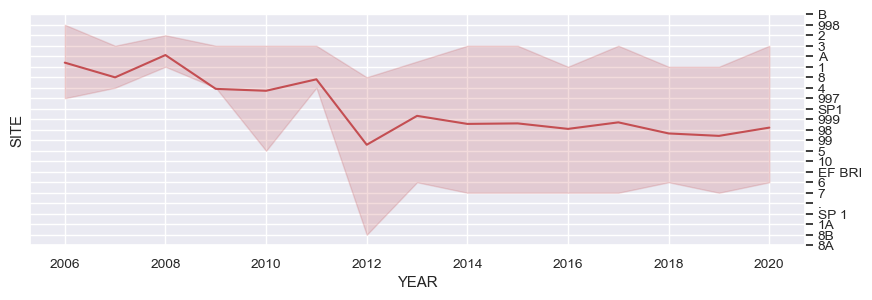


--------------------------------------------------
Data Info: RIVER_NAME 

UNIQUE numbers, strings, blanks, null = (0, 16, 0, 1)
number of numeric = 0
number of strings = 12859
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: RIVER_NAME


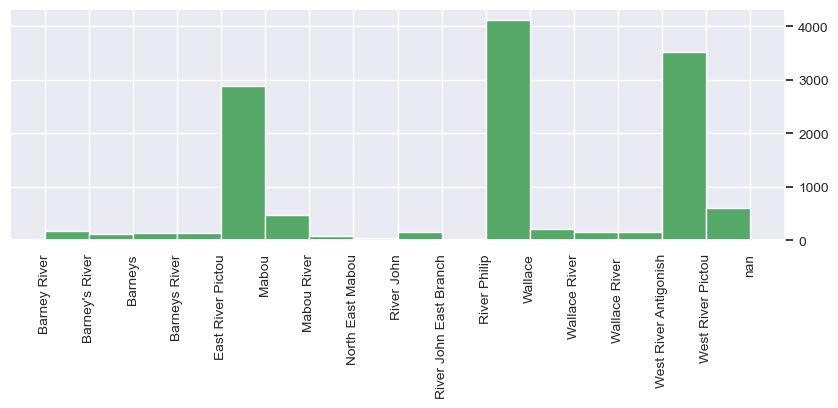


------------------------------------------------
Time Series:RIVER_NAME
CATEGORICAL


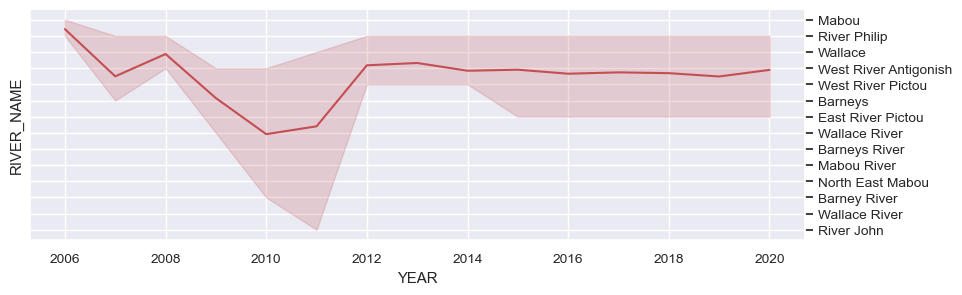


--------------------------------------------------
Data Info: SWEEP_NUMBER 

UNIQUE numbers, strings, blanks, null = (1, 0, 0, 1)
number of numeric = 12859
number of strings = 0
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: SWEEP_NUMBER


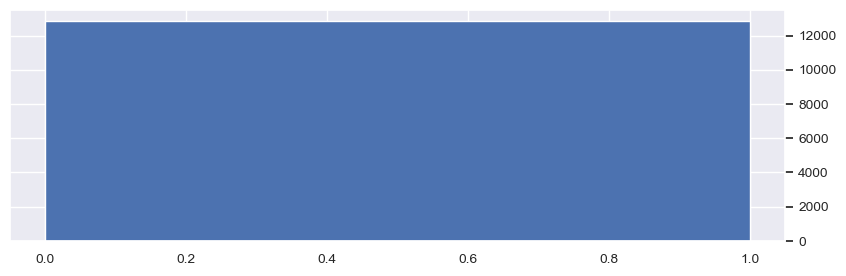


------------------------------------------------
Time Series:SWEEP_NUMBER
NUMERICAL


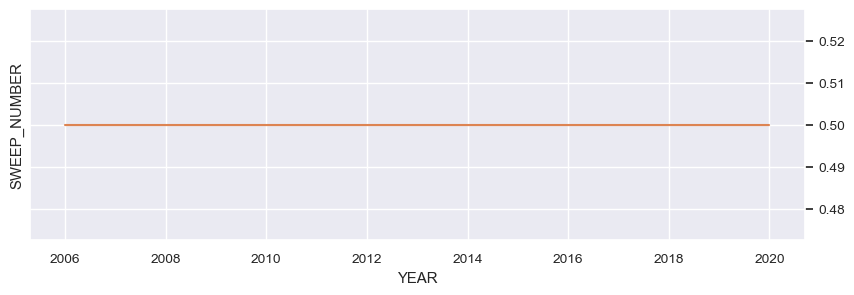


--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (17, 3, 0, 1)
number of numeric = 12852
number of strings = 3
number of blanks = 0
number of null =  40

--------------------------------------------------
Histogram: SPECIES


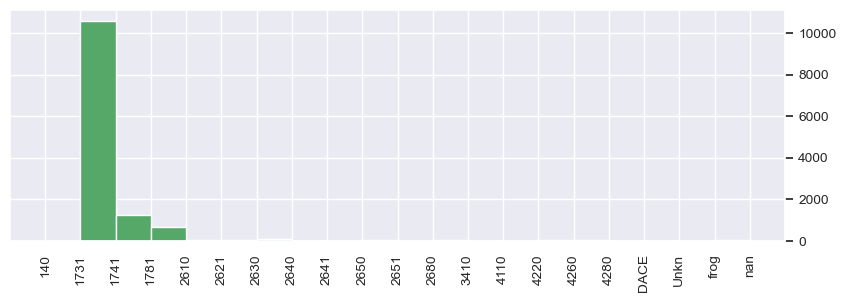


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


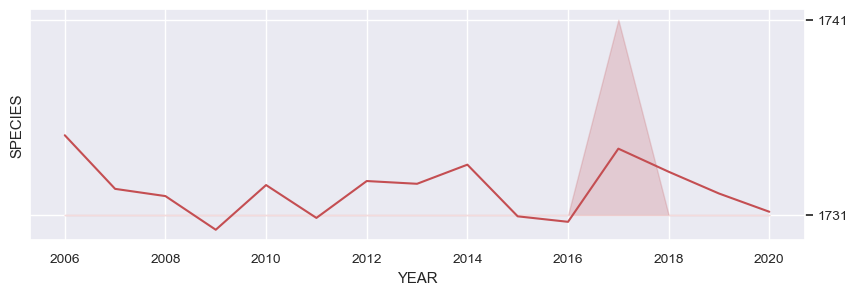


--------------------------------------------------
Data Info: ORIGIN 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 9964
number of blanks = 0
number of null =  2931

--------------------------------------------------
Histogram: ORIGIN


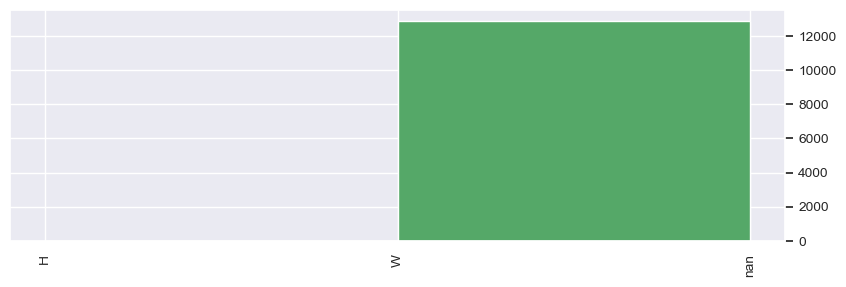


------------------------------------------------
Time Series:ORIGIN
CATEGORICAL


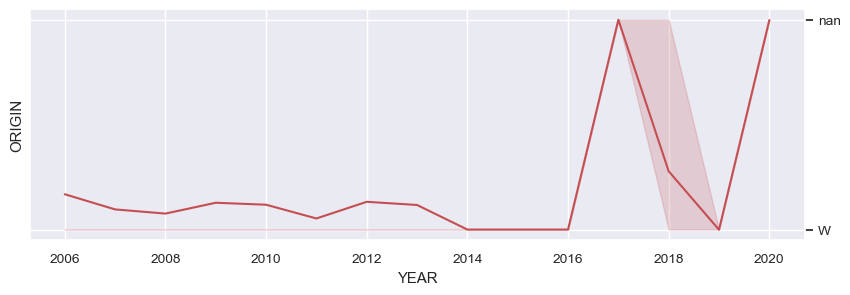


--------------------------------------------------
Data Info: FISH_STATUS 

UNIQUE numbers, strings, blanks, null = (0, 6, 0, 1)
number of numeric = 0
number of strings = 12859
number of blanks = 0
number of null =  36

--------------------------------------------------
Histogram: FISH_STATUS


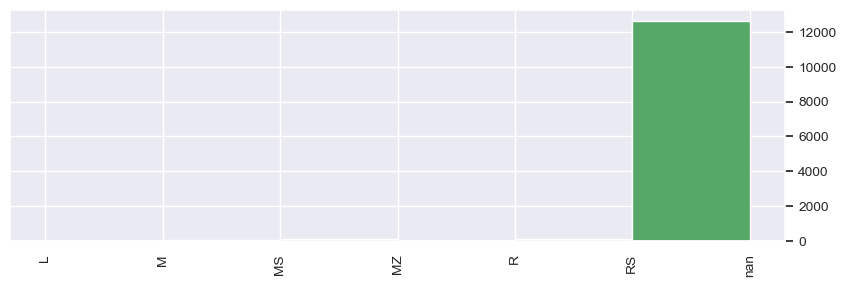


------------------------------------------------
Time Series:FISH_STATUS
CATEGORICAL


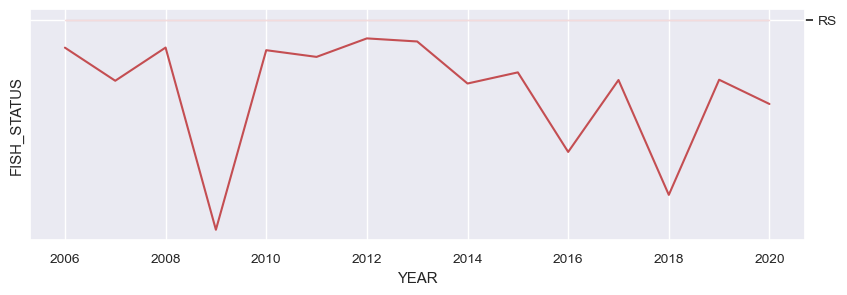


--------------------------------------------------
Data Info: FORK_LENGTH 

UNIQUE numbers, strings, blanks, null = (170, 0, 0, 1)
number of numeric = 12776
number of strings = 0
number of blanks = 0
number of null =  119

--------------------------------------------------
Histogram: FORK_LENGTH


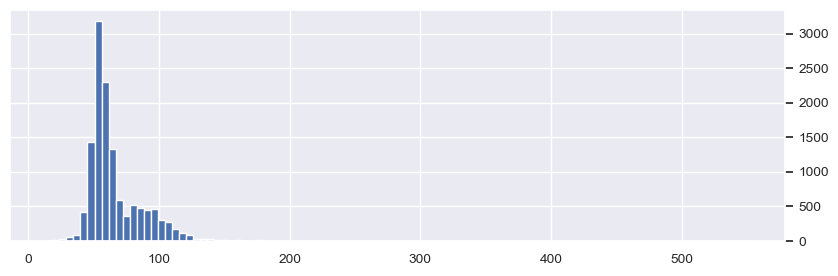


------------------------------------------------
Time Series:FORK_LENGTH
NUMERICAL


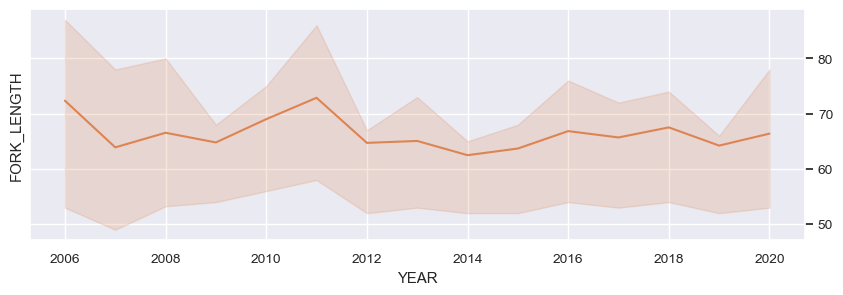


--------------------------------------------------
Data Info: TOTAL_LENGTH 

UNIQUE numbers, strings, blanks, null = (4, 0, 0, 1)
number of numeric = 5
number of strings = 0
number of blanks = 0
number of null =  12890

--------------------------------------------------
Histogram: TOTAL_LENGTH


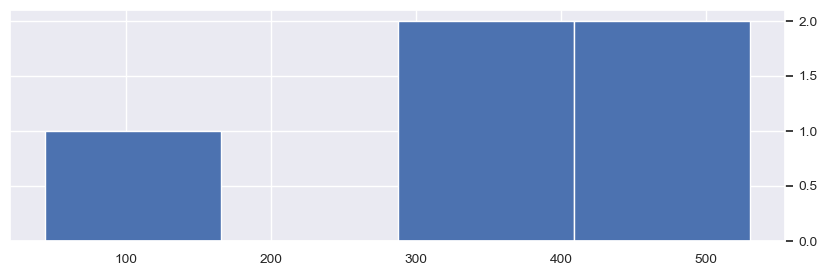


------------------------------------------------
Time Series:TOTAL_LENGTH
NUMERICAL


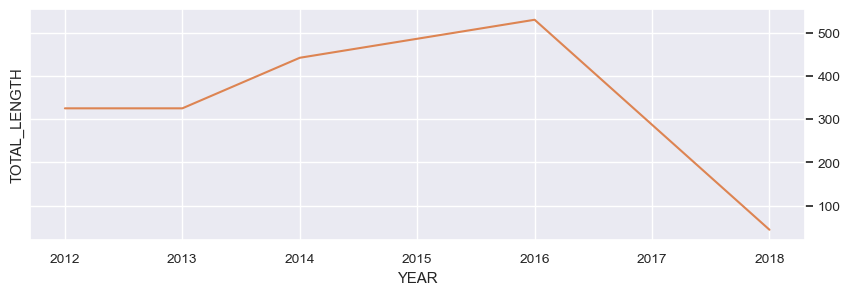


--------------------------------------------------
Data Info: CATCH_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (43, 0, 0, 0)
number of numeric = 12895
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: CATCH_FREQUENCY


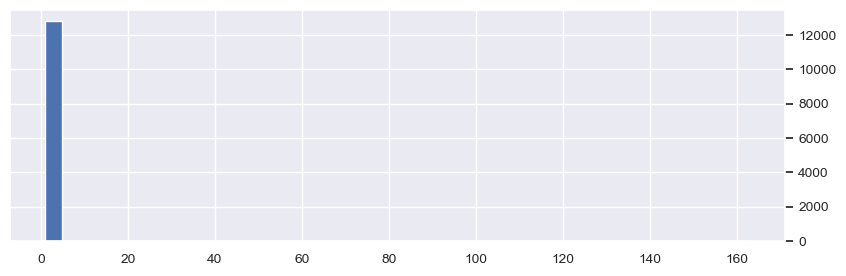


------------------------------------------------
Time Series:CATCH_FREQUENCY
NUMERICAL


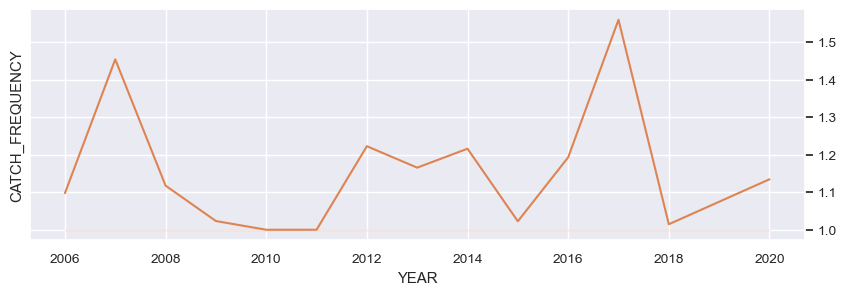


--------------------------------------------------
Data Info: FISH_SIZE 

UNIQUE numbers, strings, blanks, null = (0, 4, 0, 1)
number of numeric = 0
number of strings = 10627
number of blanks = 0
number of null =  2268

--------------------------------------------------
Histogram: FISH_SIZE


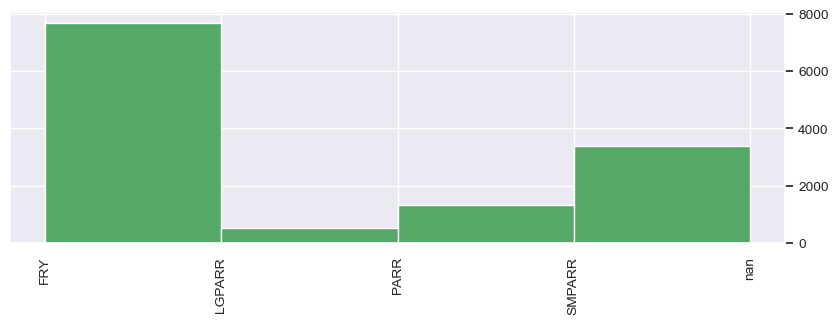


------------------------------------------------
Time Series:FISH_SIZE
CATEGORICAL


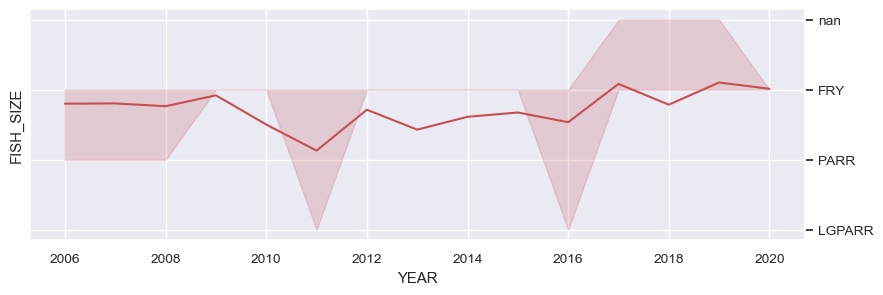


--------------------------------------------------
Data Info: RIVER_AGE 

UNIQUE numbers, strings, blanks, null = (3, 0, 0, 1)
number of numeric = 6967
number of strings = 0
number of blanks = 0
number of null =  5928

--------------------------------------------------
Histogram: RIVER_AGE


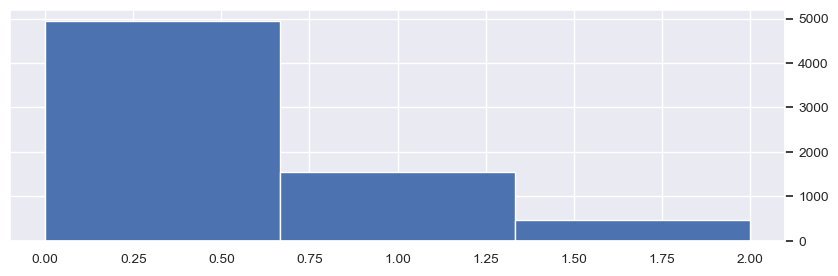


------------------------------------------------
Time Series:RIVER_AGE
NUMERICAL


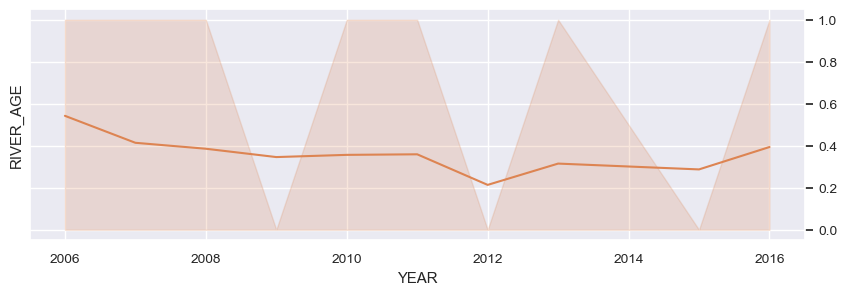


--------------------------------------------------
Data Info: AGE_TYPE 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 918
number of blanks = 0
number of null =  11977

--------------------------------------------------
Histogram: AGE_TYPE


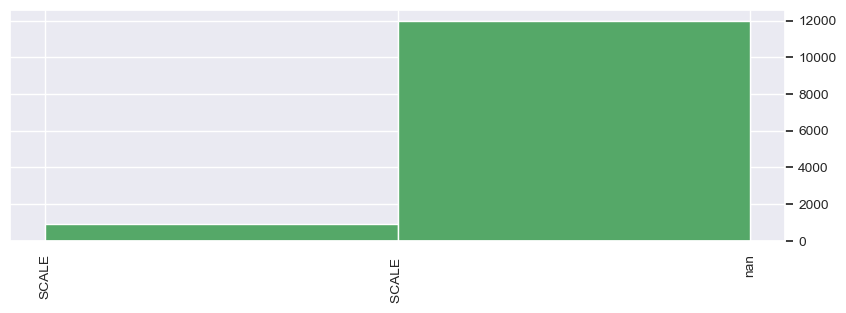


------------------------------------------------
Time Series:AGE_TYPE
CATEGORICAL


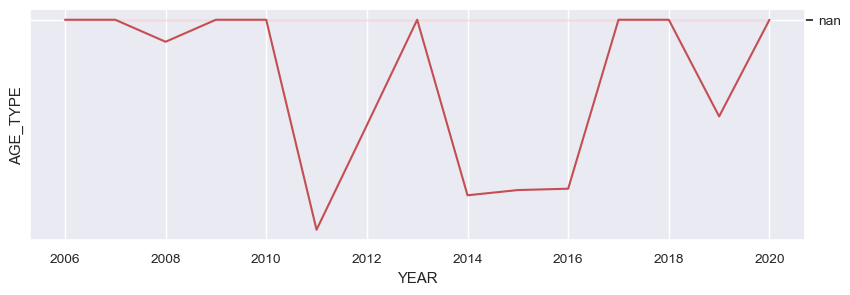


--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 2, 0, 1)
number of numeric = 0
number of strings = 1882
number of blanks = 0
number of null =  11013

--------------------------------------------------
Histogram: SEX


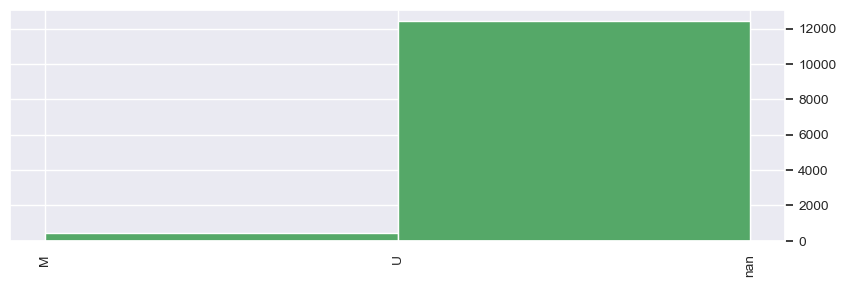


------------------------------------------------
Time Series:SEX
CATEGORICAL


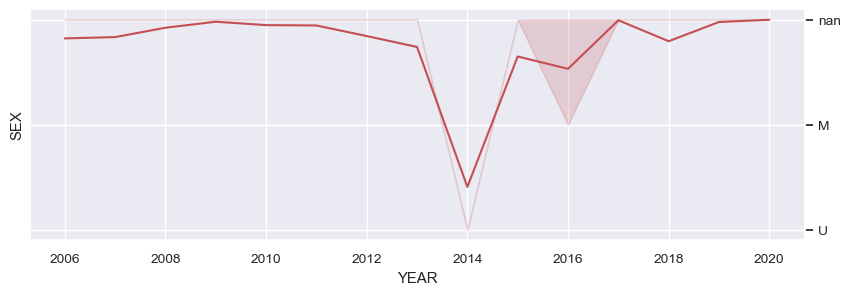


--------------------------------------------------
Data Info: WT_BIN 

UNIQUE numbers, strings, blanks, null = (66, 0, 0, 1)
number of numeric = 12649
number of strings = 0
number of blanks = 0
number of null =  246

--------------------------------------------------
Histogram: WT_BIN


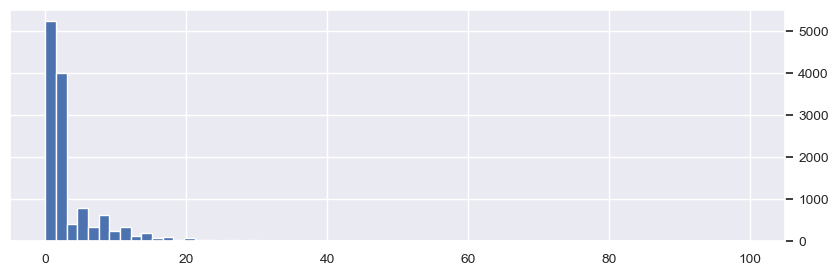


------------------------------------------------
Time Series:WT_BIN
NUMERICAL


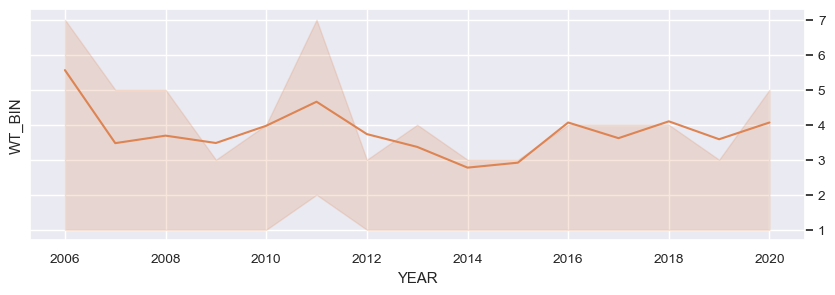

In [32]:
dont_plot_these_columns = ['ID', 'YEAR', 'WEIGHT', 'SCALE_ID_NUMBER', 'COMMENTS', 'MATURITY']
dataframe = df_gns
for col in dont_plot_these_columns:
    print_data_info(dataframe, col)
for col in [x for x in list(dataframe.columns) if x not in dont_plot_these_columns]:
    do_EDA_stuff(dataframe, col)


--------------------------------------------------
Data Info: ID 

UNIQUE numbers, strings, blanks, null = (44472, 0, 0, 0)
number of numeric = 44472
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Data Info: YEAR 

UNIQUE numbers, strings, blanks, null = (51, 0, 0, 0)
number of numeric = 44472
number of strings = 0
number of blanks = 0
number of null =  0

--------------------------------------------------
Data Info: WEIGHT 

UNIQUE numbers, strings, blanks, null = (2466, 0, 0, 1)
number of numeric = 24842
number of strings = 0
number of blanks = 0
number of null =  19630

--------------------------------------------------
Data Info: SCALE_ID_NUMBER 

UNIQUE numbers, strings, blanks, null = (238, 490, 1, 1)
number of numeric = 239
number of strings = 596
number of blanks = 1
number of null =  43637

--------------------------------------------------
Data Info: SITE 

UNIQUE numbers, strings, blanks, null = (49, 66, 0,

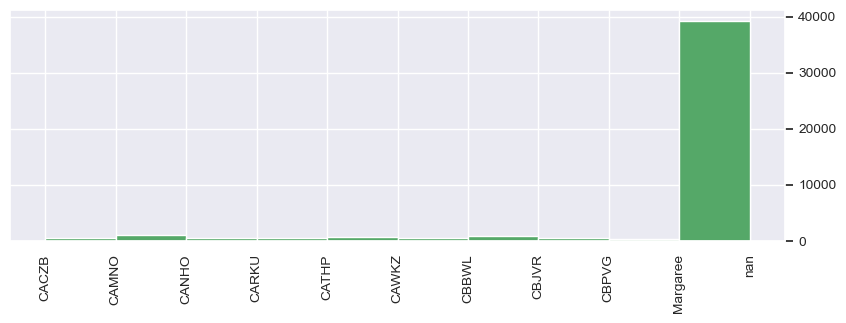


------------------------------------------------
Time Series:CGNDB
CATEGORICAL


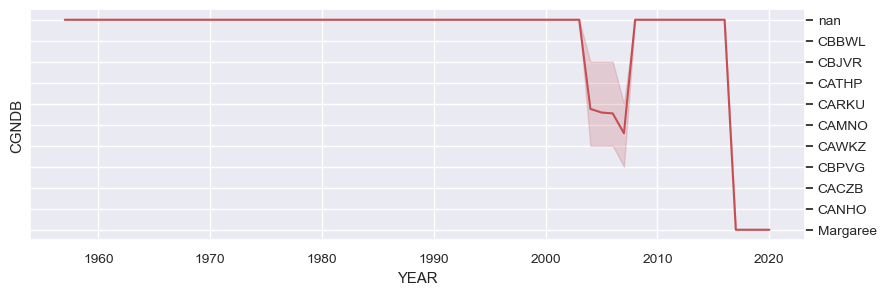


--------------------------------------------------
Data Info: SWEEP_NUMBER 

UNIQUE numbers, strings, blanks, null = (9, 2, 0, 1)
number of numeric = 40583
number of strings = 1029
number of blanks = 0
number of null =  2860

--------------------------------------------------
Histogram: SWEEP_NUMBER


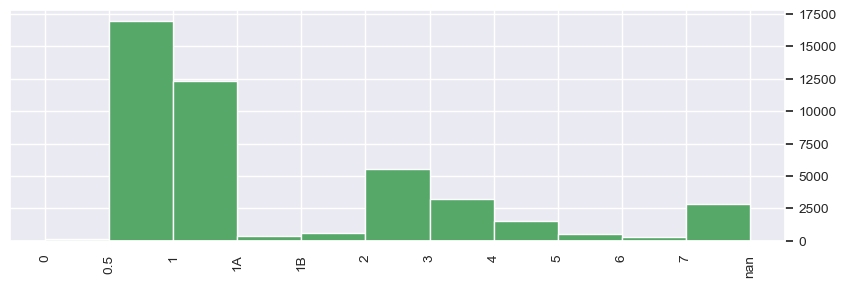


------------------------------------------------
Time Series:SWEEP_NUMBER
CATEGORICAL


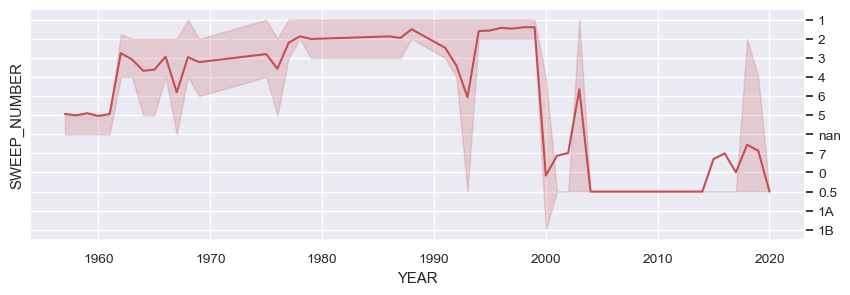


--------------------------------------------------
Data Info: SPECIES 

UNIQUE numbers, strings, blanks, null = (21, 2, 0, 0)
number of numeric = 44470
number of strings = 2
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: SPECIES


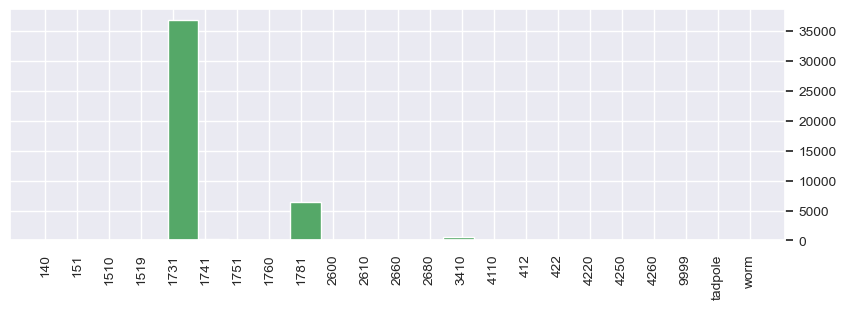


------------------------------------------------
Time Series:SPECIES
CATEGORICAL


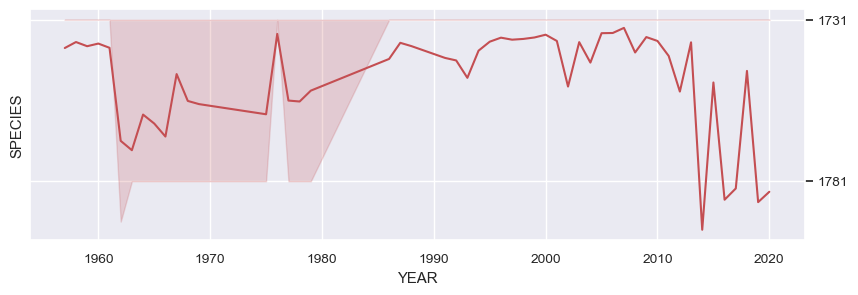


--------------------------------------------------
Data Info: ORIGIN 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 0)
number of numeric = 0
number of strings = 44472
number of blanks = 0
number of null =  0

--------------------------------------------------
Histogram: ORIGIN


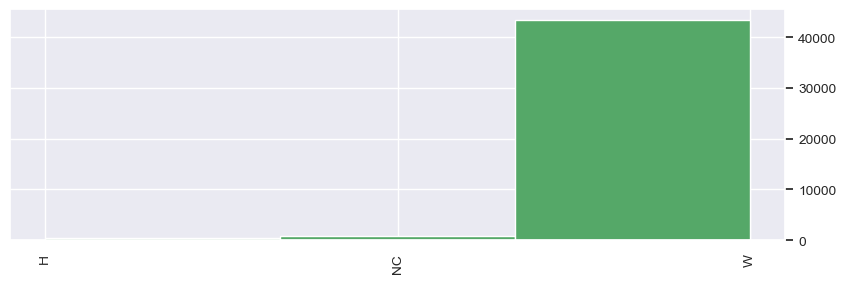


------------------------------------------------
Time Series:ORIGIN
CATEGORICAL


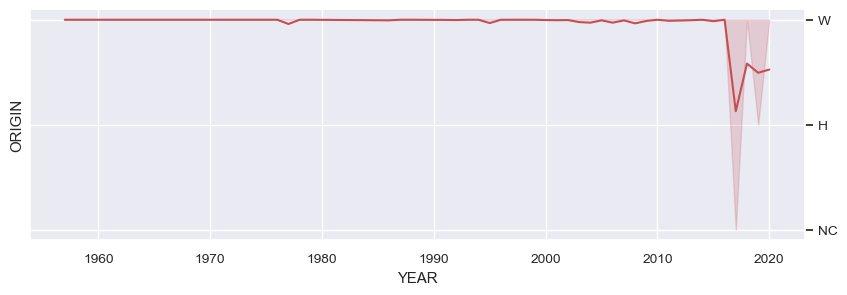


--------------------------------------------------
Data Info: FISH_STATUS 

UNIQUE numbers, strings, blanks, null = (0, 7, 0, 1)
number of numeric = 0
number of strings = 41124
number of blanks = 0
number of null =  3348

--------------------------------------------------
Histogram: FISH_STATUS


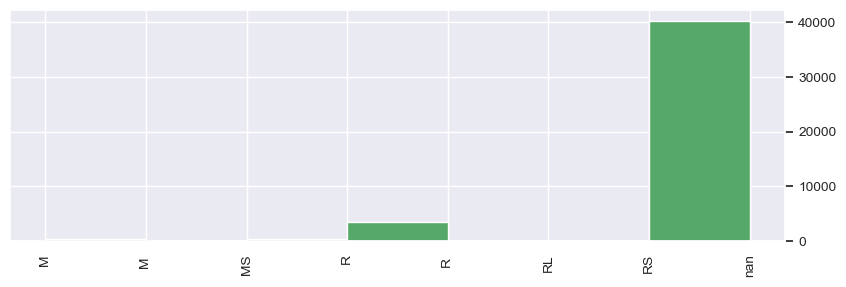


------------------------------------------------
Time Series:FISH_STATUS
CATEGORICAL


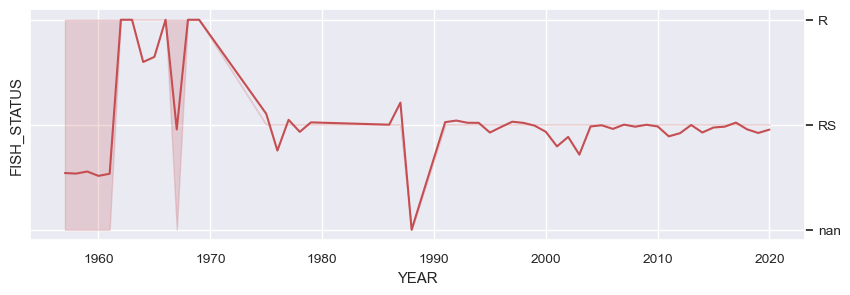


--------------------------------------------------
Data Info: FORK_LENGTH 

UNIQUE numbers, strings, blanks, null = (194, 0, 0, 1)
number of numeric = 35399
number of strings = 0
number of blanks = 0
number of null =  9073

--------------------------------------------------
Histogram: FORK_LENGTH


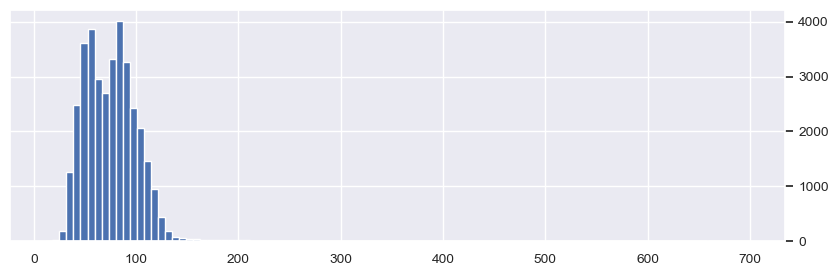


------------------------------------------------
Time Series:FORK_LENGTH
NUMERICAL


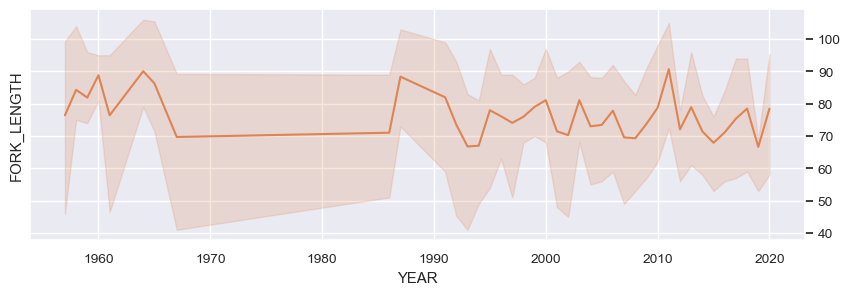


--------------------------------------------------
Data Info: CATCH_FREQUENCY 

UNIQUE numbers, strings, blanks, null = (180, 0, 0, 1)
number of numeric = 44465
number of strings = 0
number of blanks = 0
number of null =  7

--------------------------------------------------
Histogram: CATCH_FREQUENCY


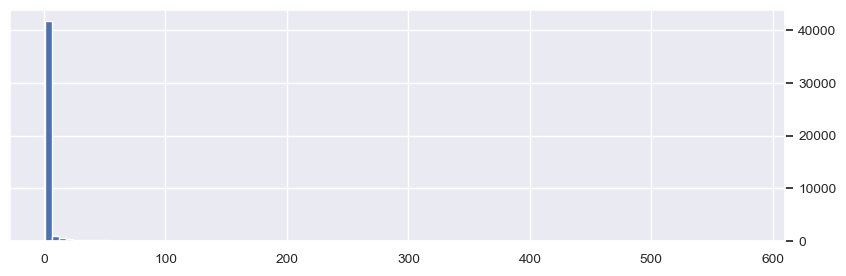


------------------------------------------------
Time Series:CATCH_FREQUENCY
NUMERICAL


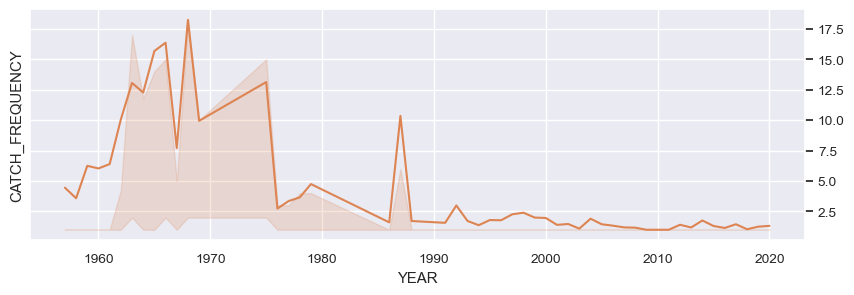


--------------------------------------------------
Data Info: FISH_SIZE 

UNIQUE numbers, strings, blanks, null = (0, 6, 0, 1)
number of numeric = 0
number of strings = 36719
number of blanks = 0
number of null =  7753

--------------------------------------------------
Histogram: FISH_SIZE


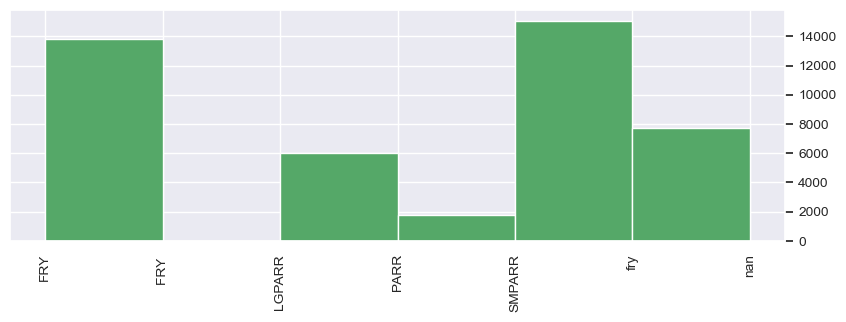


------------------------------------------------
Time Series:FISH_SIZE
CATEGORICAL


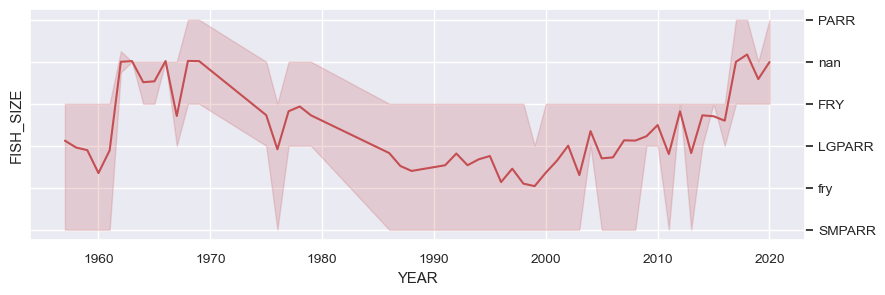


--------------------------------------------------
Data Info: RIVER_AGE 

UNIQUE numbers, strings, blanks, null = (5, 0, 0, 1)
number of numeric = 35813
number of strings = 0
number of blanks = 0
number of null =  8659

--------------------------------------------------
Histogram: RIVER_AGE


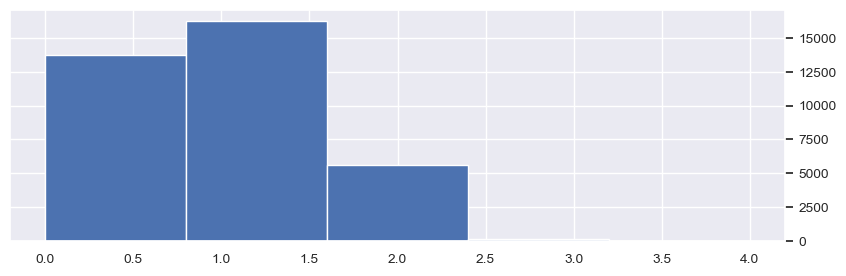


------------------------------------------------
Time Series:RIVER_AGE
NUMERICAL


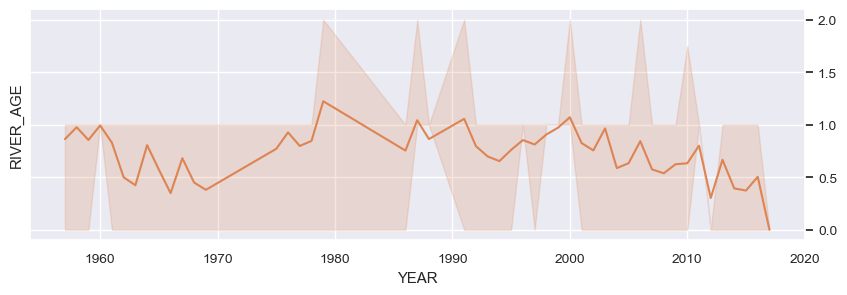


--------------------------------------------------
Data Info: AGE_TYPE 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 11548
number of blanks = 0
number of null =  32924

--------------------------------------------------
Histogram: AGE_TYPE


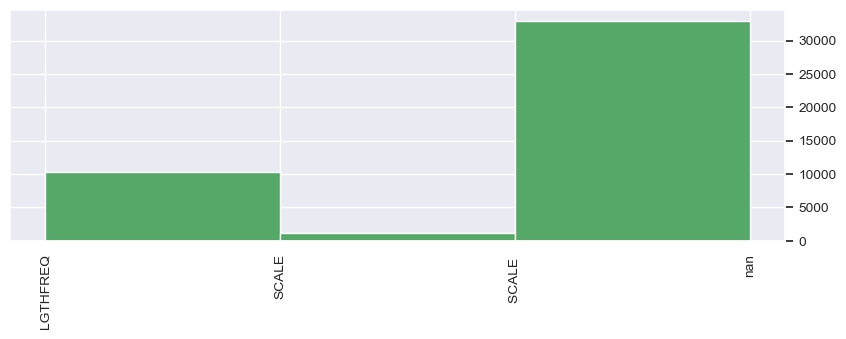


------------------------------------------------
Time Series:AGE_TYPE
CATEGORICAL


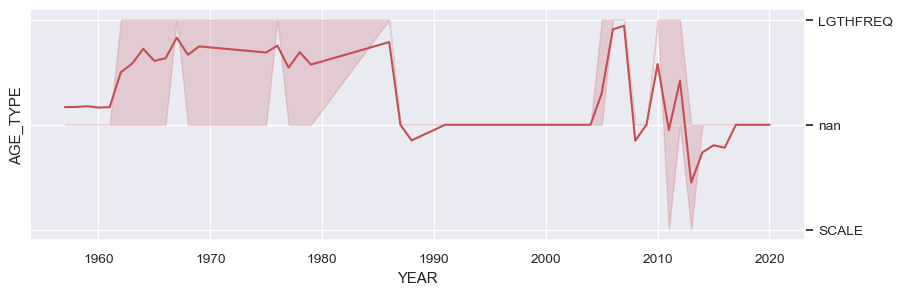


--------------------------------------------------
Data Info: SEX 

UNIQUE numbers, strings, blanks, null = (0, 3, 0, 1)
number of numeric = 0
number of strings = 3088
number of blanks = 0
number of null =  41384

--------------------------------------------------
Histogram: SEX


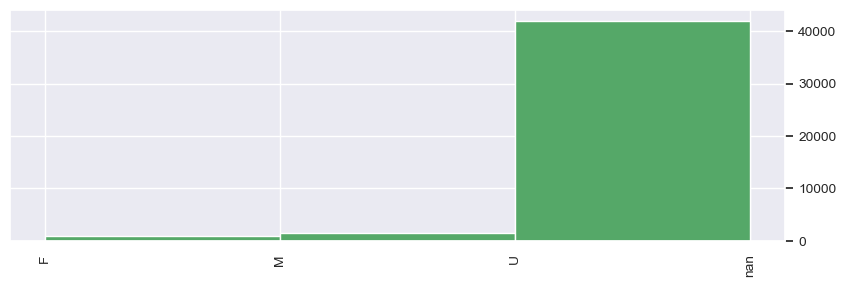


------------------------------------------------
Time Series:SEX
CATEGORICAL


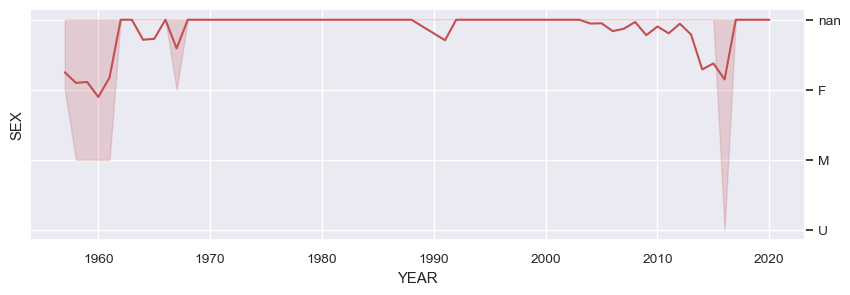


--------------------------------------------------
Data Info: MATURITY 

UNIQUE numbers, strings, blanks, null = (0, 1, 0, 1)
number of numeric = 0
number of strings = 36
number of blanks = 0
number of null =  44436

--------------------------------------------------
Histogram: MATURITY


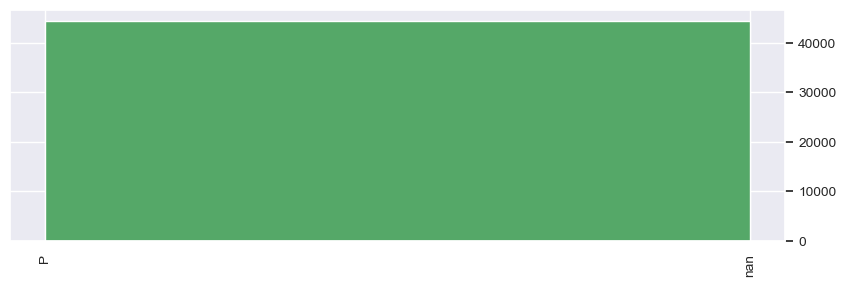


------------------------------------------------
Time Series:MATURITY
CATEGORICAL


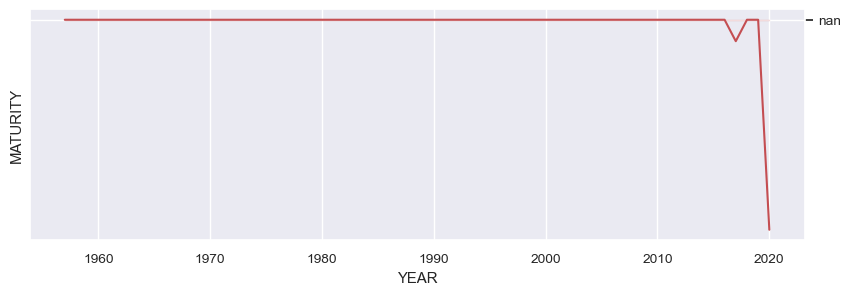


--------------------------------------------------
Data Info: WT_BIN 

UNIQUE numbers, strings, blanks, null = (74, 0, 0, 1)
number of numeric = 24842
number of strings = 0
number of blanks = 0
number of null =  19630

--------------------------------------------------
Histogram: WT_BIN


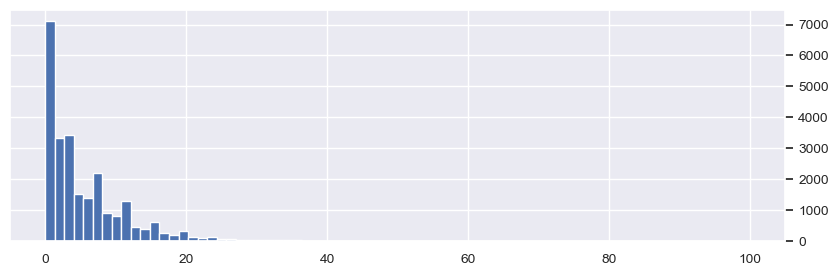


------------------------------------------------
Time Series:WT_BIN
NUMERICAL


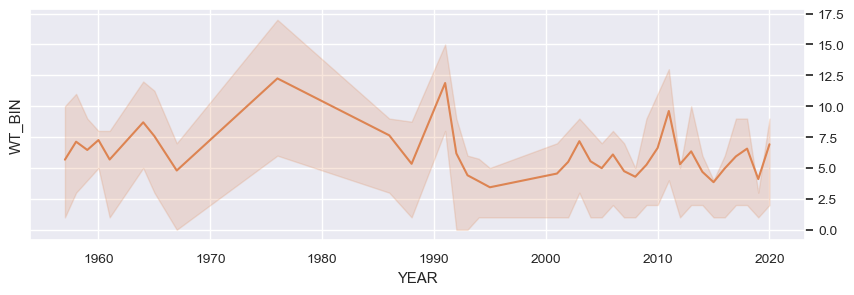

In [33]:
dont_plot_these_columns = ['ID', 'YEAR', 'WEIGHT', 'SCALE_ID_NUMBER', 'SITE', 'SPECIES_ITIS_CODE', 'TOTAL_LENGTH', 'COMMENTS', 'FORK_LENGTH_INTERVAL_WIDTH']
dataframe = df_mar
for col in dont_plot_these_columns:
    print_data_info(dataframe, col)
for col in [x for x in list(dataframe.columns) if x not in dont_plot_these_columns]:
    do_EDA_stuff(dataframe, col)